In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_6000.csv')
# df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,politikus senior pdi perjuangan panda nababan ...,Negative
1,wali kota depok mohammad idris menanggapi nyin...,Negative
2,ketua tim pemenangan nasional tpn ganjar prano...,Negative
3,aksi arogan sopir fortuner mengacungkan pedang...,Negative
4,7 bocah korban gigitan seekor monyet liar depo...,Negative
5,menteri koordinator bidang pembangunan manusia...,Negative
6,ketua tim hukum nasional amin ari yusuf menyes...,Negative
7,macet jalan tb simatupang arah pasar rebo jaka...,Negative
8,pekerja terjatuh plafon masjid at muttaqien ka...,Negative
9,eks direktur rsud padang sidimpuan sumatera ut...,Negative


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [9]:
print("Shape of tfidf_train_features:", tfidf_train_features.shape)
print("Length of y_train_encoded:", len(y_train_encoded))

Shape of tfidf_train_features: (4200, 310534)
Length of y_train_encoded: 4200


In [10]:
print("Shape of tfidf_test_features:", tfidf_test_features.shape)
print("Length of y_test_encoded:", len(y_test_encoded))

Shape of tfidf_test_features: (1800, 310534)
Length of y_test_encoded: 1800


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2024-04-22 14:29:45.832271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 14:29:47.213474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to have the same length
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

In [13]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(3, activation='softmax'))

2024-04-22 14:29:49.155645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 14:29:49.192041: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Accuracy:", accuracy)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.4276 - loss: 1.1156 - val_accuracy: 0.6861 - val_loss: 0.7643
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.7624 - loss: 0.6893 - val_accuracy: 0.7294 - val_loss: 0.7052
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.8614 - loss: 0.4225 - val_accuracy: 0.7456 - val_loss: 0.7047
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9306 - loss: 0.2556 - val_accuracy: 0.7189 - val_loss: 0.7767
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9612 - loss: 0.1707 - val_accuracy: 0.7183 - val_loss: 0.8414
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.9706 - loss: 0.1277 - val_accuracy: 0.7417 - val_loss: 0.9495
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 226ms/step - accuracy: 0.9782 - loss: 0.0972 - val_accuracy: 0.7144 - val_loss: 1.0182
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.9797 - loss: 0.0840 - val_accu

In [15]:
# Classification Report
predictions = np.argmax(model.predict(X_test_padded), axis=-1)
print(classification_report(y_test_encoded, predictions))

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       648
           1       0.68      0.70      0.69       608
           2       0.73      0.77      0.75       544

    accuracy                           0.72      1800
   macro avg       0.72      0.72      0.72      1800
weighted avg       0.72      0.72      0.72      1800



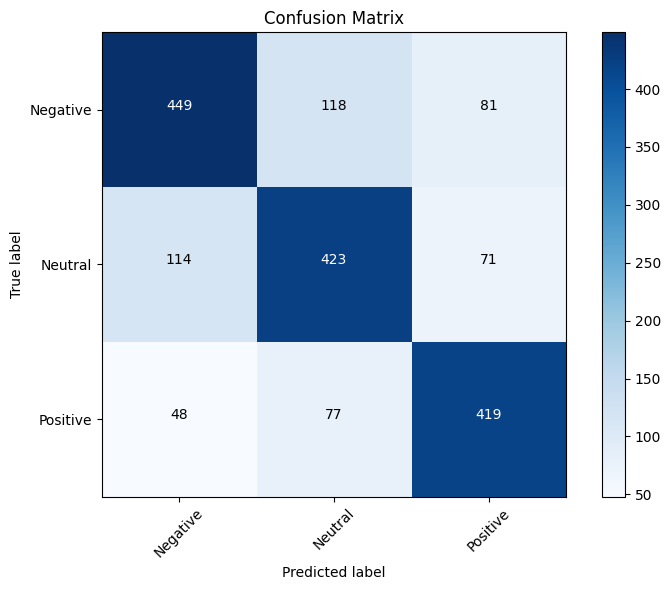

In [16]:
import itertools
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

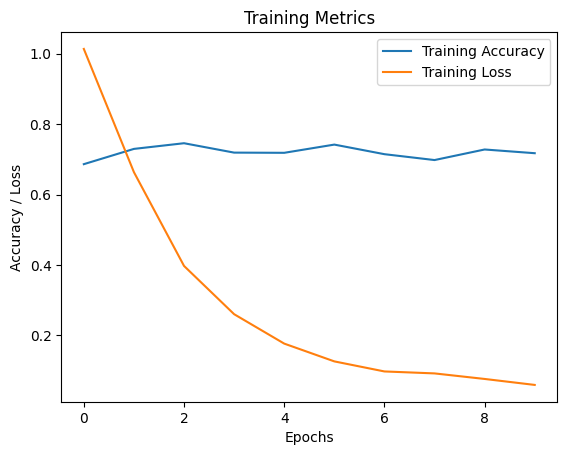

In [18]:
plt.plot(history.history['val_accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Metrics')
plt.legend()
plt.show()